In [1]:
#autoreload
%load_ext autoreload
%autoreload 2
import torch
import matplotlib.pyplot as plt
import numpy as np
import featureman.gen_data as man
import featureman.utils as utils
from sklearn.cluster import SpectralClustering
import pickle
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
sae_dict = torch.load("sae_model_small_batch_2025-08-07_00-27-27.pth", map_location=device)
sae = man.BatchedSAE_Updated(input_dim=512, n_models=5, width_ratio=4).to(device)
sae.load_state_dict(sae_dict)

model_dict = torch.load("modular_arithmetic_model.pth", map_location=device)
model = man.OneLayerTransformer(p=113, d_model=128, nheads=4).to(device)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [3]:
torch.manual_seed(1337)
# generate combination of all inputs a and b range (113)
a_values = np.arange(113)
b_values = np.arange(113)
# generate inputs for the model
inputs = np.array([[a_i, 113, b_i, 114] for a_i in a_values for b_i in b_values])
inputs = torch.tensor(inputs).to(device)  # Add batch dimension

logits, activations = model(inputs, return_activations=True)
activation_final = activations[:, -1, :].detach()
batched_acts = activation_final.unsqueeze(0).repeat(5, 1, 1).to(device)

In [5]:
import pickle

decoder = sae.W_d[3].detach() #2048 x 512

_, _, feat_acts, _ = sae(batched_acts)
features = feat_acts[3].detach() # 12769 x 512

with open("clusters_2_sim_cutoff_0.5.pkl", "rb") as f:
    clusters = pickle.load(f)
    clusters = [c for c in clusters if len(c) > 1]  # Filter out clusters with only one element

clusters = sorted(clusters, key=lambda x: len(x), reverse=True)  # Sort by size


In [7]:
clusters

[]

{0: [{'type': 'cos', 'frequency': 6, 'magnitude': 893.82214}, {'type': 'sin', 'frequency': 6, 'magnitude': 149.4167}, {'type': 'sin', 'frequency': 12, 'magnitude': 140.82005}], 1: [{'type': 'sin', 'frequency': 54, 'magnitude': 680.3617}, {'type': 'cos', 'frequency': 54, 'magnitude': 328.87894}, {'type': 'sin', 'frequency': 6, 'magnitude': 220.84369}], 2: [{'type': 'cos', 'frequency': 44, 'magnitude': 717.37024}, {'type': 'sin', 'frequency': 44, 'magnitude': 254.22794}, {'type': 'sin', 'frequency': 54, 'magnitude': 81.174034}], 3: [{'type': 'sin', 'frequency': 44, 'magnitude': 553.93475}, {'type': 'sin', 'frequency': 6, 'magnitude': 397.372}, {'type': 'cos', 'frequency': 44, 'magnitude': 187.40045}], 4: [{'type': 'sin', 'frequency': 6, 'magnitude': 461.44073}, {'type': 'sin', 'frequency': 44, 'magnitude': 334.2618}, {'type': 'sin', 'frequency': 54, 'magnitude': 245.47939}], 5: [{'type': 'cos', 'frequency': 54, 'magnitude': 542.64825}, {'type': 'sin', 'frequency': 6, 'magnitude': 238.728

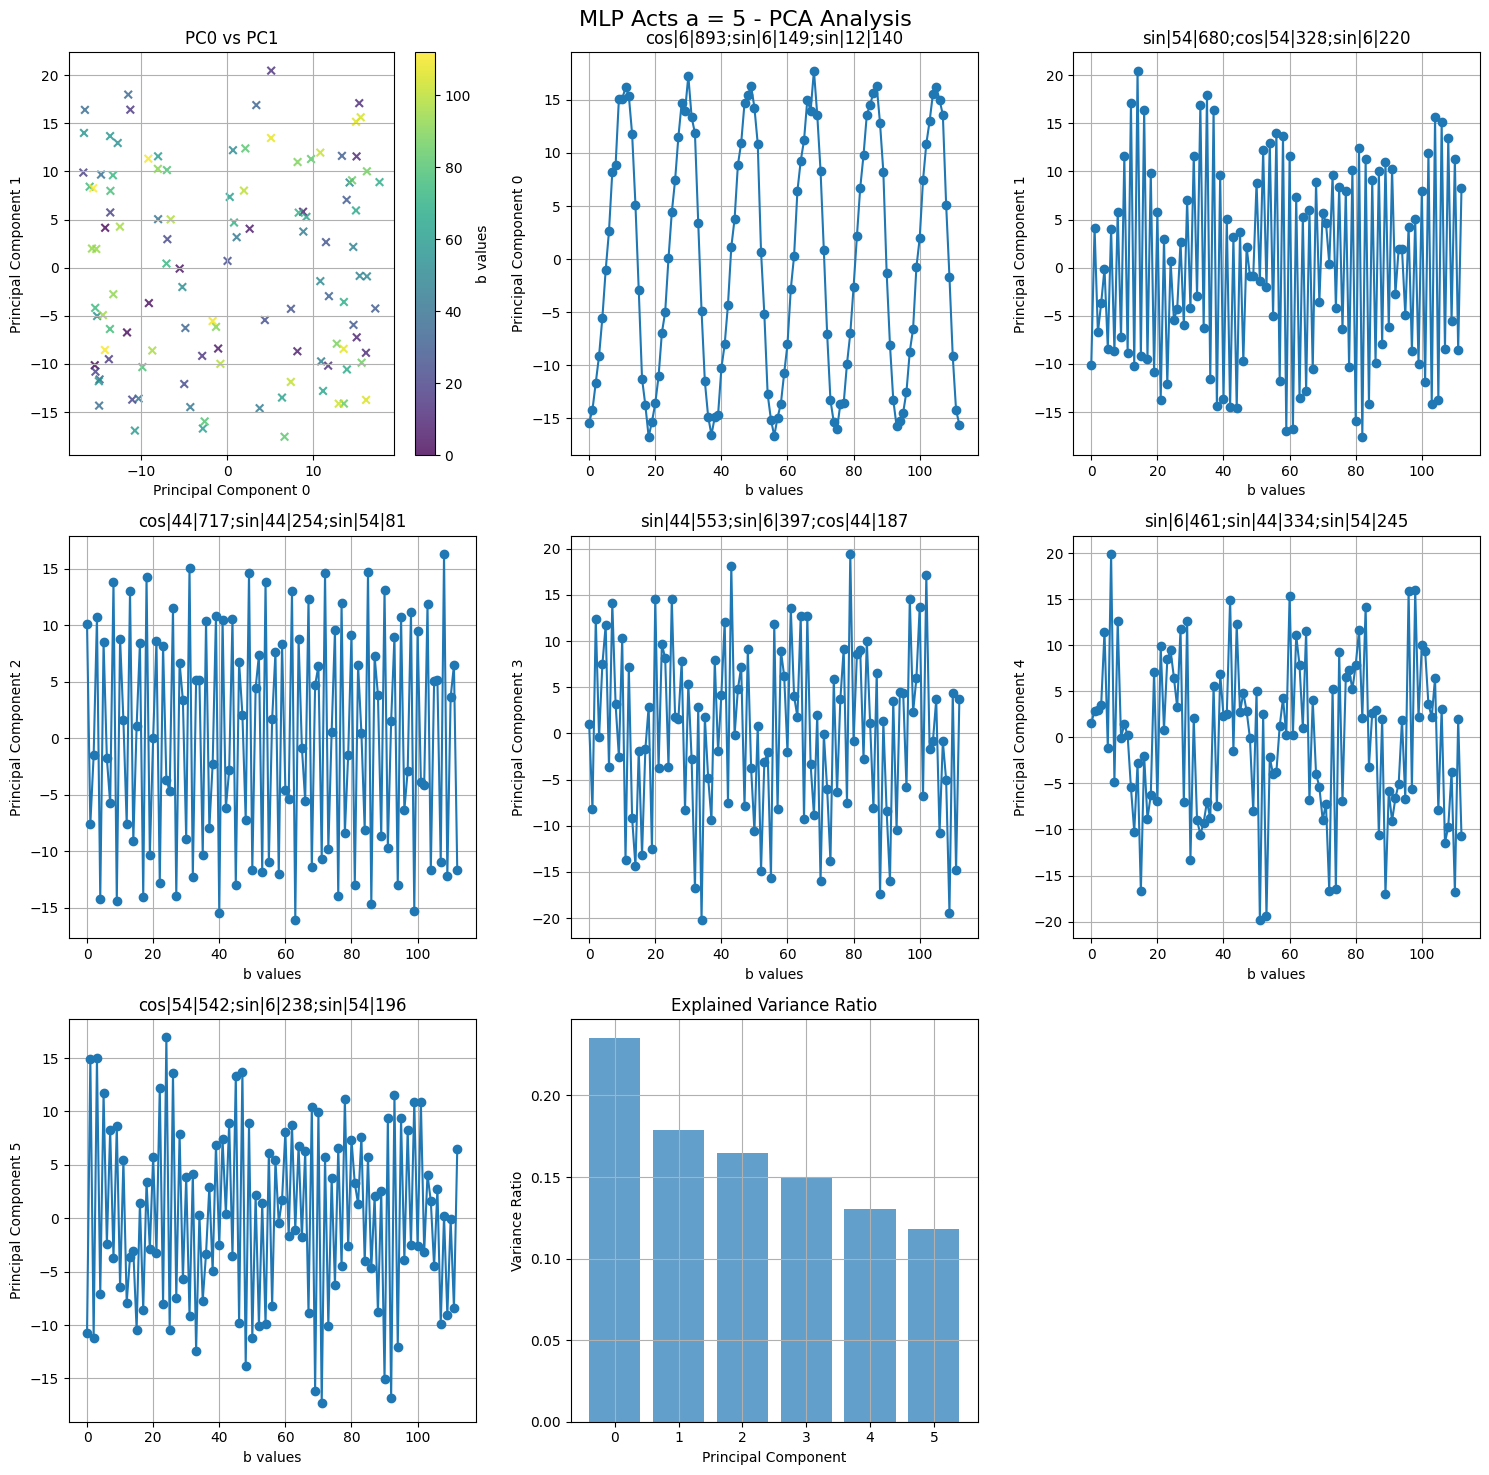

In [6]:
fixed_a = 5
mlp_a_fixed = batched_acts[3][fixed_a*113:fixed_a*113+113].detach().cpu().numpy()

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
#mlp truth
pca = PCA(n_components=6).fit(mlp_a_fixed)
output_pca = pca.transform(mlp_a_fixed)

top_freqs = utils.plot_pca_fourier_components(output_pca, plot=False)
print(top_freqs)

plt.subplot(3, 3, 1)
scatter = plt.scatter(output_pca[:, 0][:], output_pca[:, 1][:], marker='x', c=b_values[:], s=30, alpha=0.8, cmap='viridis')
plt.title("PC0 vs PC1")
plt.xlabel("Principal Component 0")
plt.ylabel("Principal Component 1")
plt.grid()
plt.colorbar(scatter, label='b values')

plt.subplot(3, 3, 2)
plt.plot(b_values[:], output_pca[:, 0][:], marker='o')
plt.title(";".join(f"{freq['type']}|{freq['frequency']}|{int(freq['magnitude'])}" 
                   for freq in top_freqs[0][:3]))
plt.xlabel("b values")
plt.ylabel("Principal Component 0")
plt.grid()

plt.subplot(3, 3, 3)
plt.plot(b_values[:], output_pca[:, 1][:], marker='o')
plt.title(";".join(f"{freq['type']}|{freq['frequency']}|{int(freq['magnitude'])}" 
                   for freq in top_freqs[1][:3]))
plt.xlabel("b values")
plt.ylabel("Principal Component 1")
plt.grid()

plt.subplot(3, 3, 4)
plt.plot(b_values[:], output_pca[:, 2][:], marker='o')
plt.title(";".join(f"{freq['type']}|{freq['frequency']}|{int(freq['magnitude'])}" 
                   for freq in top_freqs[2][:3]))
plt.xlabel("b values")
plt.ylabel("Principal Component 2")
plt.grid()

plt.subplot(3, 3, 5)
plt.plot(b_values[:], output_pca[:, 3][:], marker='o')
plt.title(";".join(f"{freq['type']}|{freq['frequency']}|{int(freq['magnitude'])}" 
                   for freq in top_freqs[3][:3]))
plt.xlabel("b values")
plt.ylabel("Principal Component 3")
plt.grid()

plt.subplot(3, 3, 6)
plt.plot(b_values[:], output_pca[:, 4][:], marker='o')
plt.title(";".join(f"{freq['type']}|{freq['frequency']}|{int(freq['magnitude'])}" 
                   for freq in top_freqs[4][:3]))
plt.xlabel("b values")
plt.ylabel("Principal Component 4")
plt.grid()

plt.subplot(3, 3, 7)
plt.plot(b_values[:], output_pca[:, 5][:], marker='o')
plt.title(";".join(f"{freq['type']}|{freq['frequency']}|{int(freq['magnitude'])}" 
                   for freq in top_freqs[5][:3]))
plt.xlabel("b values")
plt.ylabel("Principal Component 5")
plt.grid()

#explained variance bar plot
plt.subplot(3, 3, 8)
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, alpha=0.7)
plt.title("Explained Variance Ratio")
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio")
plt.xticks(range(len(pca.explained_variance_ratio_)))
plt.grid()

plt.suptitle(f"MLP Acts a = {fixed_a} - PCA Analysis", fontsize=16)

plt.tight_layout()
plt.show()

for i in range(len(clusters)):
    features_interest = features[:, clusters[i]]
    decoder_interest = decoder[clusters[i], :]
    reconstructions = features_interest @ decoder_interest
    recon_a = reconstructions[fixed_a*113:fixed_a*113+113].detach().cpu().numpy()

    pca = PCA(n_components=6).fit(recon_a)
    output_pca = pca.transform(recon_a)
    top_freqs = utils.plot_pca_fourier_components(output_pca, plot=False)


    plt.figure(figsize=(15, 5))

    # Subplot 1: PC0 vs PC1
    plt.subplot(1, 3, 1)
    #explained variance bar plot
    plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, alpha=0.7)
    plt.title("Explained Variance Ratio")
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Ratio")
    plt.xticks(range(len(pca.explained_variance_ratio_)))
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(b_values[:], output_pca[:, 0][:], marker='o')
    plt.title(";".join(f"{freq['type']}|{freq['frequency']}|{int(freq['magnitude'])}" 
                   for freq in top_freqs[0][:3]))
    plt.xlabel("b values")
    plt.ylabel("Principal Component 0")
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(b_values[:], output_pca[:, 1][:], marker='o')
    plt.title(";".join(f"{freq['type']}|{freq['frequency']}|{int(freq['magnitude'])}" 
                   for freq in top_freqs[1][:3]))
    plt.xlabel("b values")
    plt.ylabel("Principal Component 1")
    plt.grid()
    #sup title
    plt.suptitle(f"Cluster {i + 1} - Size: {len(clusters[i])}", fontsize=16)

    plt.tight_layout()
    plt.show()